In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import pickle
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

In [2]:
df = pd.read_csv("transaction_dataset.csv")
df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

In [4]:
df.columns = df.columns.str.strip()
columns_to_drop = ['Unnamed: 0', 'Index', 'Total ERC20 tnxs'] + [col for col in df.columns if col.startswith('ERC20')]
df = df.drop(columns=columns_to_drop)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 24 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Address                                               9841 non-null   object 
 1   FLAG                                                  9841 non-null   int64  
 2   Avg min between sent tnx                              9841 non-null   float64
 3   Avg min between received tnx                          9841 non-null   float64
 4   Time Diff between first and last (Mins)               9841 non-null   float64
 5   Sent tnx                                              9841 non-null   int64  
 6   Received Tnx                                          9841 non-null   int64  
 7   Number of Created Contracts                           9841 non-null   int64  
 8   Unique Received From Addresses                        9841

In [6]:
df

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total APT sent,total APT received,total APT sent contracts,total APT balance
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421897,0.0,-50.896986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,11,4,...,12.200000,9.166365,0.0,0.0,0.0,17,36.665461,36.673777,0.0,0.008316
9837,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0,0.000000,0.000000,0.0,0.000000
9838,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,31,44,...,9.500000,0.922179,0.0,0.0,0.0,110,61.785995,53.070252,0.0,-8.715743
9839,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,1,0,...,0.000000,0.000000,0.0,0.0,0.0,1,0.000000,0.500000,0.0,0.500000


In [7]:
df = df.drop(columns=["Address"])

In [8]:
df.FLAG.value_counts()

FLAG
0    7662
1    2179
Name: count, dtype: int64

In [9]:
X = df.drop(columns=['FLAG']) 
y = df['FLAG'] 

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle=True, random_state = 42)

In [11]:
model1 = DecisionTreeClassifier()
model2 = RandomForestClassifier(class_weight='balanced', random_state=42)
model3 = xgb.XGBClassifier()

def model_train(model, x_train, y_train, x_test, y_test):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print('Accuracy Score: ',accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    with open(str(model)[:3] + '_mdl.pkl', 'wb') as f:
        pickle.dump(model,f)

In [12]:
model_train(model1, X_train, y_train, X_test, y_test)

Accuracy Score:  0.9380097879282219
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1530
           1       0.93      0.94      0.94      1535

    accuracy                           0.94      3065
   macro avg       0.94      0.94      0.94      3065
weighted avg       0.94      0.94      0.94      3065



In [13]:
model_train(model2, X_train, y_train, X_test, y_test)

Accuracy Score:  0.964437194127243
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1530
           1       0.96      0.97      0.96      1535

    accuracy                           0.96      3065
   macro avg       0.96      0.96      0.96      3065
weighted avg       0.96      0.96      0.96      3065



In [14]:
model_train(model3, X_train, y_train, X_test, y_test)

Accuracy Score:  0.966721044045677
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1530
           1       0.96      0.97      0.97      1535

    accuracy                           0.97      3065
   macro avg       0.97      0.97      0.97      3065
weighted avg       0.97      0.97      0.97      3065



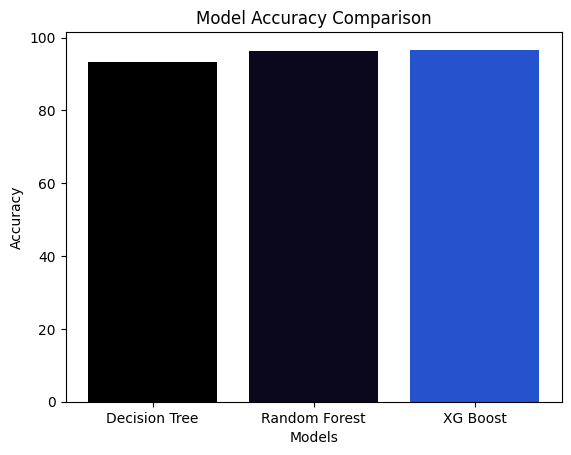

In [ ]:
accuracy = [93.3768352365416, 96.44371941272430, 96.6721044045677]
models = ['Decision Tree', 'Random Forest', 'XG Boost']

plt.bar(models, accuracy, color=['#000000', '#302380', '#2553ce'])

plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')

plt.show()

In [16]:
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)
y_pred = [list(y_pred1), list(y_pred2), list(y_pred3)]
n = len(y_pred[0])

In [17]:
pred_list = []
for i in range(n):
    prediction_list = [y_pred1[i], y_pred2[i], y_pred3[i]]
    counter = Counter(prediction_list)
    most_common_prediction = counter.most_common(1)
    pred_list.append(most_common_prediction[0][0])

In [18]:
y_pred = np.array(pred_list)
print('Accuracy Score: ',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy Score:  0.9631321370309951
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1530
           1       0.96      0.97      0.96      1535

    accuracy                           0.96      3065
   macro avg       0.96      0.96      0.96      3065
weighted avg       0.96      0.96      0.96      3065

